# Problem description


A small factory in Dalian, China, has an issue with reviewing many hours of security footage every day. These reviews are an essential part of their routine security checks and regulation compliance. The factory found that these reviews are both time-consuming and costly, and error-prone. <br>

I proposed a lightweight and computationally cheap solution to this problem, which involves identifying unique frames in this footage by employing a simple data science approach. <br>

# Problem formulation and methodology
The project’s goal is to reduce search time in security camera footage by finding unique frames.

I sample each video at a rate of 1 frame/sec, then calculate the consecutive frames’ dis-similarity scores via the Euclidean distance equation. 

I analyzed several videos and found that most frames have close similarity values. Substantially dissimilar frames contain unusual objects; in most cases containing people who walked into the camera’s recording field, which is the purpose of the security recordings. Thus, I empirically chose a distance threshold, after which a frame is considered to be substantially dis-similar.

Approach cut down the search time by approximately 95% without introducing significant computational costs.

I demonstrate the utility of my approach using the publically available Kaggle dataset in the following link:
https://www.kaggle.com/chunshanfeng/security-camera-video


# Roadmap

I solved this problem in the following steps<br>

1. Read the video file
2. Extract frames from the video
3. Change the frames to grey images
4. Change grey images to smaller sizes
5. Calculate neighbouring images distance
6. Clip the video, then connect together
7. Conclusion

### 1. Read the video file

In [9]:
# import libraries
import cv2
import os
import datetime
import time
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline 
#import warnings
#warnings.filterwarnings("ignore")

# Read the video    
vidcap = cv2.VideoCapture('security.mp4')

### 2, Extract frames from the video
 I capture image in each one second. Usually, there are over 20 frames in one second. If we capture every frame, the time interval is tiny, even people move in the video, the consecutive frames don't have much difference. The small interval is not good.  If people move in the video, usually the time span will be over four seconds, so I choose to capture image in each one second.

In [10]:
from PIL import Image
from matplotlib.pyplot import imshow
sec = 0
frameRate = 1   #//it will capture image in each 1 second
count=1

frame_array = []
def getFrame(sec):
    # This function get frames from video
    global result,diff
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrames,image = vidcap.read()
    frame_array.append(image)
    return hasFrames

success = getFrame(sec)
while success:
    count = count + 1
    sec = sec + frameRate
    sec = round(sec, 2)
    success = getFrame(sec)
   

I display several images

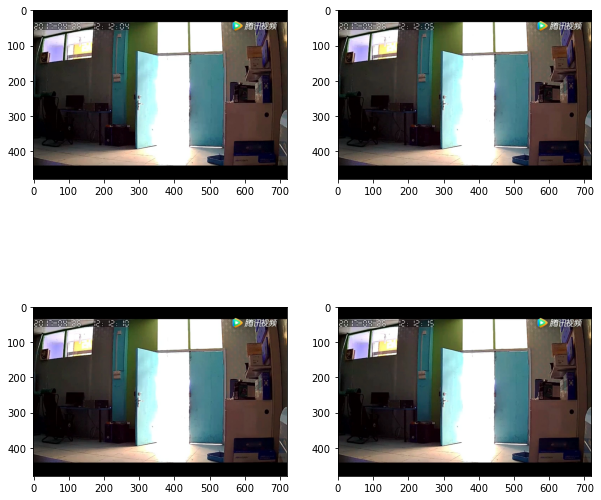

In [11]:
import matplotlib.pyplot as plt
img = Image.fromarray(frame_array[0], 'RGB')

rows=2
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(frame_array):
            axes[i, j].imshow(frame_array[img_count])
            img_count+=5

### 3. Change the frames to grey images

A grayscale (or graylevel) image is simply one in which the only colors are shades of gray. The reason is that less information needs to be provided for each pixel. 
We use gray scale due to the irrelevance of colour to this problem. Furthermore, gray scale reduces computation cost.

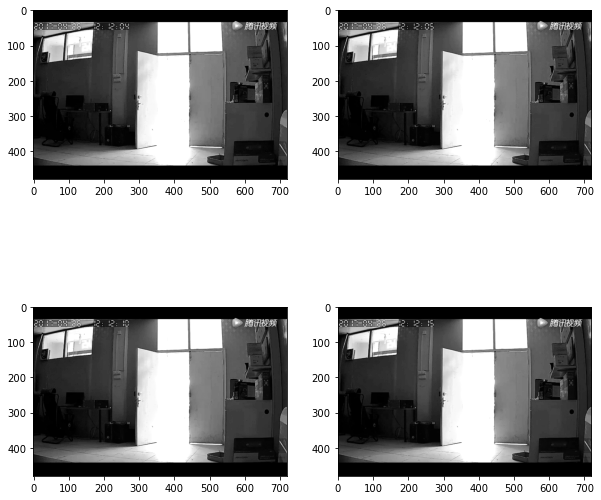

In [12]:
grey_frame_array = []  # save grey images in this list

for i in range(len(frame_array)-1):
    gray = cv2.cvtColor(frame_array[i], cv2.COLOR_BGR2GRAY)
    grey_frame_array.append(gray)
    

# I display four grey images    
rows=2
cols = 2
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(10,10))

for i in range(rows):
    for j in range(cols):        
        if img_count < len(frame_array):
            axes[i, j].imshow(grey_frame_array[img_count],cmap='gray')
            img_count+=5

### 4, Change grey images to smaller sizes
The reason is that we can calculate faster with smaller sizes of images.

In [13]:
resized_array = [] # save smaller sizes images in this list

width=128
height=72
dim = (width, height)        
for i in range(len(grey_frame_array)):
        # Change to smaller size
        img=grey_frame_array[i]
       
        # Resize image
        resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA) 
        # scale pixel values to the range 0-1, reduce the outlier pixel value effect
        resized=resized/255
        resized_array.append(resized)

### 5, Calculate neighbouring images distance

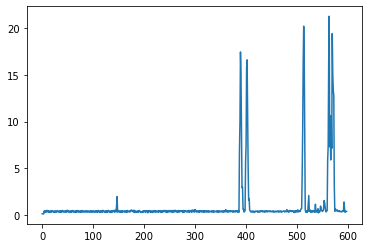

In [14]:
diff=[] # save the neighbouring images distance in this list
for i in range(len(resized_array)):
     if i>0:
          
        lastimage=resized_array[i-1]
        image=resized_array[i]
        difference = cv2.subtract(lastimage, image)
        diff2= np.sum(difference**2)
        diff2=np.sqrt(diff2)
        diff.append(diff2)    
plt.plot(diff)
plt.show()

From the above chart, we can find three areas have peaks. The continuous images are not similar in these three areas. It seems that we can choose the distance threshold value 3 to distinguish these three peaks area with other flat areas.

### 6, Clip the video, then connect together
I will collect specific clips from the video. These clips will start with the frame which the distance is larger than the threshold value, and end with the frame which the distance is less than the threshold. 
Then I combine these clips together into a shorter video.

In [15]:
from moviepy.editor import *
clip = VideoFileClip('security.mp4')
final_clip=clip.subclip(1, 1)
start_time=0
end_time=0

threshold=int(input('Please enter the distance threshlod, the reference value is 3: '))

for i in range(len(diff)):
    if i>0:
        if diff[i]>threshold and diff[i-1]<threshold:
            start_time=i-1
        if diff[i]<threshold and diff[i-1]>threshold:
            end_time=i-1
        if end_time>start_time:
            clip2=clip.subclip(start_time, end_time)
            final_clip = concatenate_videoclips([final_clip,clip2])
            end_time=0
            start_time=0

ipython_display(final_clip)

Please enter the distance threshlod, the reference value is 3: 3


chunk:   0%|▏                                                                | 2/706 [00:00<01:00, 11.63it/s, now=None]

Moviepy - Building video __temp__.mp4.
MoviePy - Writing audio in __temp__TEMP_MPY_wvf_snd.mp3


t:   0%|▏                                                                    | 2/800 [00:00<00:42, 18.69it/s, now=None]

MoviePy - Done.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


### 7, Conclusion
From the final smaller video, I think using Euclidean distance methods to calculate the distance of the neighbouring image is an effective method to find the frames with people in a security camera video.